In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE, root_mean_squared_error as RMSE
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor
from skrub import TableVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import holidays
import math
import seaborn as sns

# Exploratory Data Analysis (EDA):

In [2]:
data = pd.read_parquet('data/train.parquet')
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.091042


In [3]:
#get first day and last day for each dataset 
print(f"Data ranges from {data['date'].min()} to {data['date'].max()}")

Data ranges from 2020-09-01 01:00:00 to 2021-09-09 23:00:00


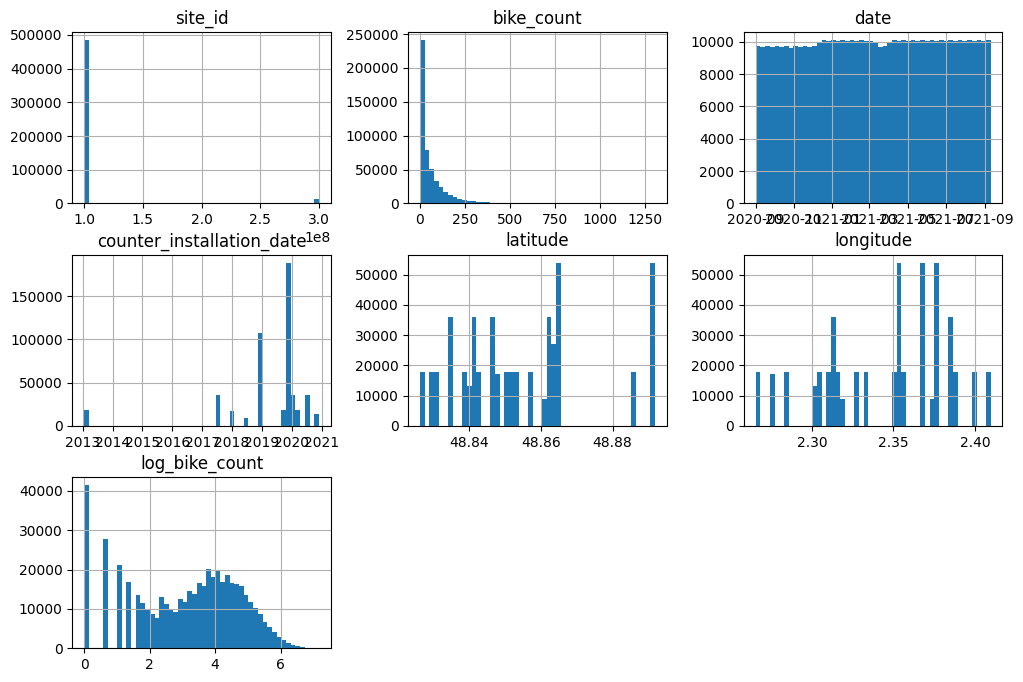

In [4]:
# Let's check the distribution of numerical data in our dataset. 
data.hist(bins=50, figsize=(12,8))
plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\1351760388.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = data.groupby("counter_id")


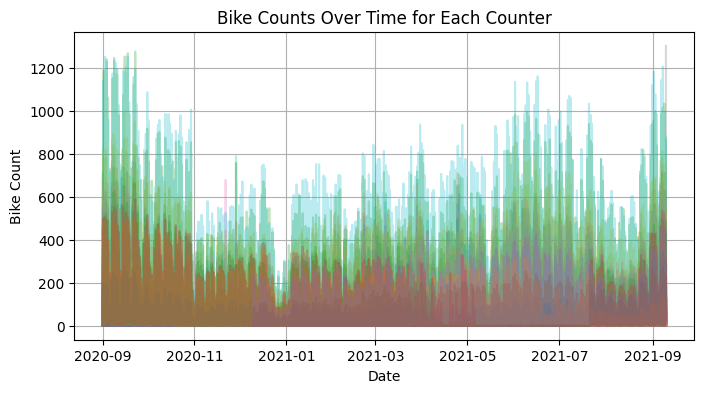

In [5]:
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values(["counter_name", "date"])

groups = data.groupby("counter_id")

# Create a plot
plt.figure(figsize=(8, 4))
for counter_id, group in groups:
    plt.plot(
        group["date"], group["bike_count"], alpha=0.3, label=f"Counter ID: {counter_id}"
    )
    # break

plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.title("Bike Counts Over Time for Each Counter")
# plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize='small')
plt.grid(True)
plt.show()

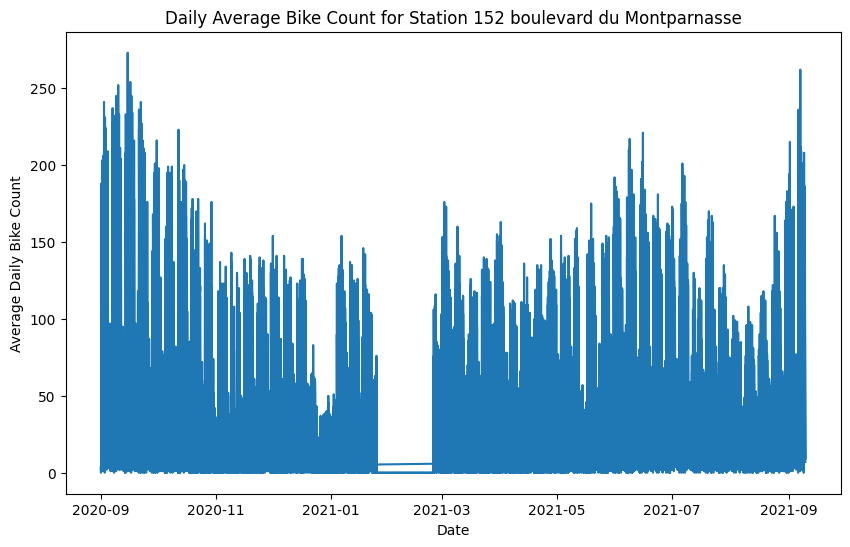

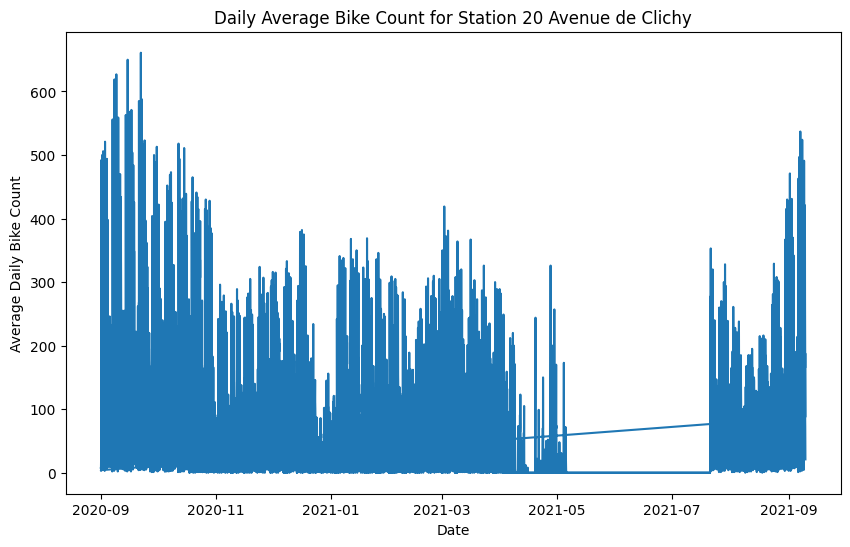

In [6]:

# Check what is goinf on with these 2 stations
stations = ["152 boulevard du Montparnasse", "20 Avenue de Clichy"]

for station in stations:
    station_data = data[data['site_name'] == station]
    plt.figure(figsize=(10, 6))
    plt.plot(station_data['date'], station_data['bike_count'])
    plt.title(f'Daily Average Bike Count for Station {station}')
    plt.xlabel('Date')
    plt.ylabel('Average Daily Bike Count')
    plt.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2066827182.py:9: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  data[mask].groupby(["counter_name", pd.Grouper(freq="1w", key="date")], observed = True)["bike_count"].sum().unstack(0).plot(figsize = (12,6), legend = 'upper right')


<Axes: xlabel='date'>

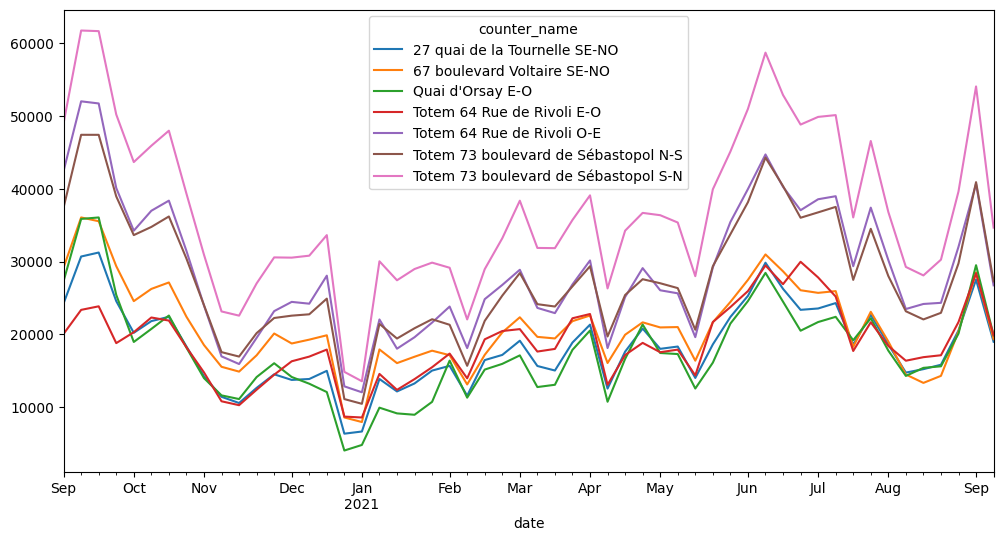

In [7]:
# We want to aggregate more counters on the same plot, we think that 7 is a good number to observe a trend.
# Find the top 10 counters by total bike count
top_counters = data.groupby("counter_name", observed = True)["bike_count"].sum().nlargest(7).index

# Create a mask for these top counters
mask = data["counter_name"].isin(top_counters)

# Group by week and plot
data[mask].groupby(["counter_name", pd.Grouper(freq="1w", key="date")], observed = True)["bike_count"].sum().unstack(0).plot(figsize = (12,6), legend = 'upper right')


We can see from this graph that there are some gaps in the data, notably around 2021-01 and 2021-05

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\286459556.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_data = data.groupby(['site_name', 'date'])['bike_count'].mean().reset_index()
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\286459556.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  panel_data['consecutive'] = panel_data.groupby(['site_name', (panel_data['zero_bike_count'].shift() != panel_data['zero_bike_count']).cumsum()]).cumcount()+1
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\286459556.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to T

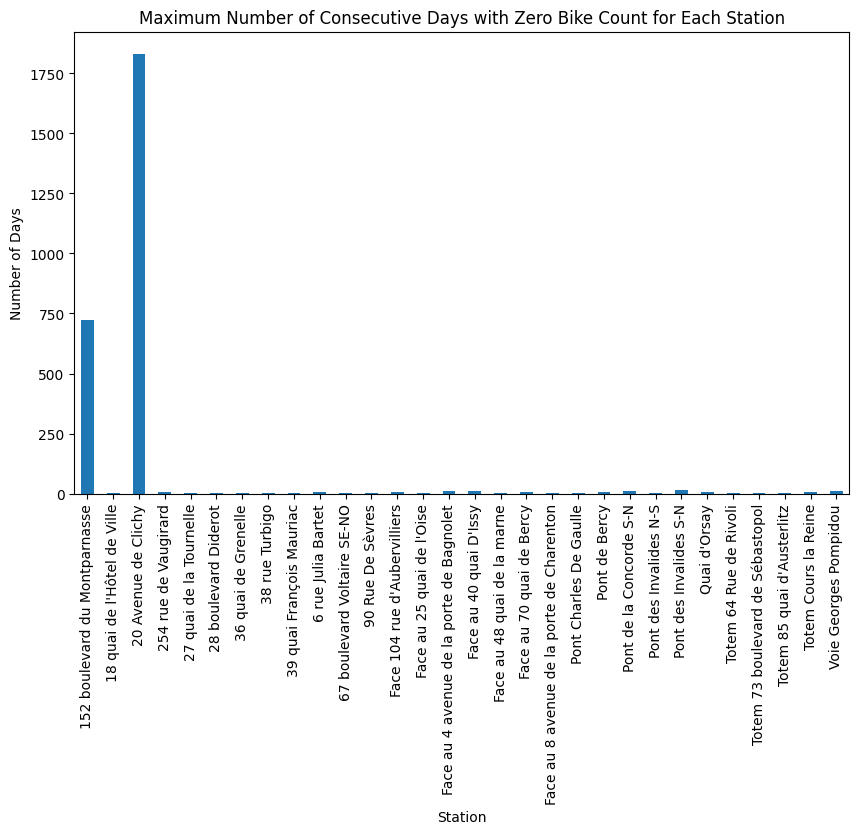

In [8]:
# Group by station and date, calculate the mean of bike_count
panel_data = data.groupby(['site_name', 'date'])['bike_count'].mean().reset_index()

# Add a column for days with zero bike count
panel_data['zero_bike_count'] = (panel_data['bike_count'] == 0)

# Group by station and count consecutive days with zero bike count
panel_data['consecutive'] = panel_data.groupby(['site_name', (panel_data['zero_bike_count'].shift() != panel_data['zero_bike_count']).cumsum()]).cumcount()+1

# Find the maximum number of consecutive days with zero bike count for each station
max_zero_bike_count = panel_data[panel_data['zero_bike_count']].groupby('site_name')['consecutive'].max()

# Plot the results
max_zero_bike_count.plot(kind='bar', figsize=(10, 6))
plt.title('Maximum Number of Consecutive Days with Zero Bike Count for Each Station')
plt.xlabel('Station')
plt.ylabel('Number of Days')
plt.show()

In [9]:
# Drop redundant columns:

data = data.drop(
    [
        "site_id",
        "site_name",
        "bike_count",
        "counter_installation_date",
        "counter_technical_id",
        "latitude",
        "longitude",
    ],
    axis=1,
)

In [10]:
def add_rush_hour(data):
    # Create 'hour' column temporarily
    data['hour'] = data['date'].dt.hour

    # Use the temporary 'hour' column to calculate 'is_rush_hour'
    data['is_rush_hour'] = data['hour'].apply(lambda x: 1 if (7 <= x <= 9 or 17 <= x <= 19) else 0)

    # Drop the temporary 'hour' column
    data = data.drop(columns=['hour'])
    
    return data


In [11]:
def extract_date_features(data, date_column='date'):
    # Create weekend_day: 1 if weekend, 0 otherwise
    data['weekend_day'] = data[date_column].dt.dayofweek.apply(lambda x: 1 if x in [5, 6] else 0)

    # Create season based on the month
    data['season'] = data[date_column].dt.month.apply(
        lambda x: 'spring' if x in [3, 4, 5]
        else 'winter' if x in [12, 1, 2]
        else 'summer' if x in [6, 7, 8]
        else 'autumn'
    )

    # Check for holidays in France
    france_holidays = holidays.France(years=data[date_column].dt.year.unique())
    data['holidays'] = data[date_column].apply(lambda d: 1 if d in france_holidays else 0)
    
    return data

In [12]:
def strikes (data):
    greves = pd.read_csv("mouvements-sociaux-depuis-2002.csv", sep=';')
    greves = greves[(greves['Date'] > '2020-09-01')]
    # only keep rows with date before 19 october 2021
    greves = greves[(greves['Date'] < '2021-10-19')]
    data['strike'] = data['date'].isin(greves['Date']).astype(int)
    return data

In [13]:
data = extract_date_features(data)
data = strikes(data)
data = add_rush_hour(data)
data

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\660285707.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[us] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data['strike'] = data['date'].isin(greves['Date']).astype(int)


,counter_id,counter_name,date,coordinates,log_bike_count,weekend_day,season,holidays,strike,is_rush_hour
400125,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 01:00:00,"48.840801,2.333233",1.609438,0,autumn,0,0,0
401371,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 02:00:00,"48.840801,2.333233",0.000000,0,autumn,0,0,0
398510,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 03:00:00,"48.840801,2.333233",1.098612,0,autumn,0,0,0
398513,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 04:00:00,"48.840801,2.333233",2.833213,0,autumn,0,0,0
400128,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 05:00:00,"48.840801,2.333233",4.060443,0,autumn,0,0,0
...,...,...,...,...,...,...,...,...,...,...
135579,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 19:00:00,"48.8484,2.27586",3.663562,0,autumn,0,0,1
135982,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 20:00:00,"48.8484,2.27586",3.555348,0,autumn,0,0,0
135582,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 21:00:00,"48.8484,2.27586",3.526361,0,autumn,0,0,0
134570,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 22:00:00,"48.8484,2.27586",3.258097,0,autumn,0,0,0


In [14]:
# Additionally add some interpolation for holidays and strikes. (also look at pietro micelli fro strikes visualisation)

# Weather data

In [15]:
weather = pd.read_csv('external_data/external_data.csv', parse_dates=["date"])

In [16]:
data['date'] = pd.to_datetime(data['date'])
weather['date'] = pd.to_datetime(weather['date'])

In [17]:
# Define the renaming dictionary
rename_dict = {
    'dd': 'mean_wind_direction',
    'ff': 'mean_wind_speed',
    't': 'temperature',
    'td': 'dew_point',
    'u': 'humidity_perc',
    'vv': 'horizontal_visibility',
    'ww': 'present_weather',  # potentially categorical - check
    'w1': 'past_time',
    'w2': 'past_time_2',  # potentially to take out
    'nbas': 'cloudiness_lower_level',
    'pres': 'atmospheric_pressure',
    'raf10': 'max_wind_gust_speed',
    'rafper': 'max_wind_gust_over_period',
    'etat_sol': 'state_of_ground',
    'ht_neige': 'depth_of_snow_ice_or_other',
    'ssfrai': 'height_of_snow',
    'rr1': 'rain_1',
    'rr3': 'rain_3',
    'rr6': 'rain_6',
    'rr9': 'rain_9'
}

# Rename the columns in-place
weather.rename(columns=rename_dict, inplace=True)


In [18]:
threshold = 0.7  # 90% threshold

# Calculate the percentage of NaN values for each column
nan_percentage = weather.isnull().mean()

# Identify columns where NaN percentage is greater than the threshold
columns_to_drop = nan_percentage[nan_percentage > threshold].index

# Print the columns that will be dropped
print(f"Columns dropped (NaN > 70%): {list(columns_to_drop)}")

# Drop those columns from the dataset
weather = weather.drop(columns=columns_to_drop)

# View the resulting dataset
weather

Columns dropped (NaN > 70%): ['niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4']


,numer_sta,date,pmer,tend,cod_tend,mean_wind_direction,mean_wind_speed,temperature,dew_point,humidity_perc,...,rain_3,rain_6,rr12,rr24,nnuage1,ctype1,hnuage1,nnuage2,ctype2,hnuage2
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,0.0,0.0,0.0,2.0,1.0,6.0,600.0,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,0.0,0.0,0.0,1.2,1.0,6.0,1500.0,2.0,3.0,3000.0
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,0.0,0.0,0.0,1.0,3.0,6.0,480.0,4.0,6.0,2000.0
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,0.2,0.2,0.2,0.2,1.0,6.0,1740.0,3.0,3.0,2800.0
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,0.0,0.2,0.2,0.2,1.0,8.0,330.0,4.0,6.0,570.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,0.0,0.0,0.0,2.2,5.0,6.0,400.0,7.0,6.0,2200.0
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,0.2,0.2,0.2,1.6,2.0,8.0,870.0,7.0,6.0,1900.0
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,0.0,0.2,0.2,0.2,2.0,8.0,820.0,7.0,6.0,2200.0
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,0.0,0.0,0.2,0.2,8.0,6.0,2160.0,NaN,NaN,NaN


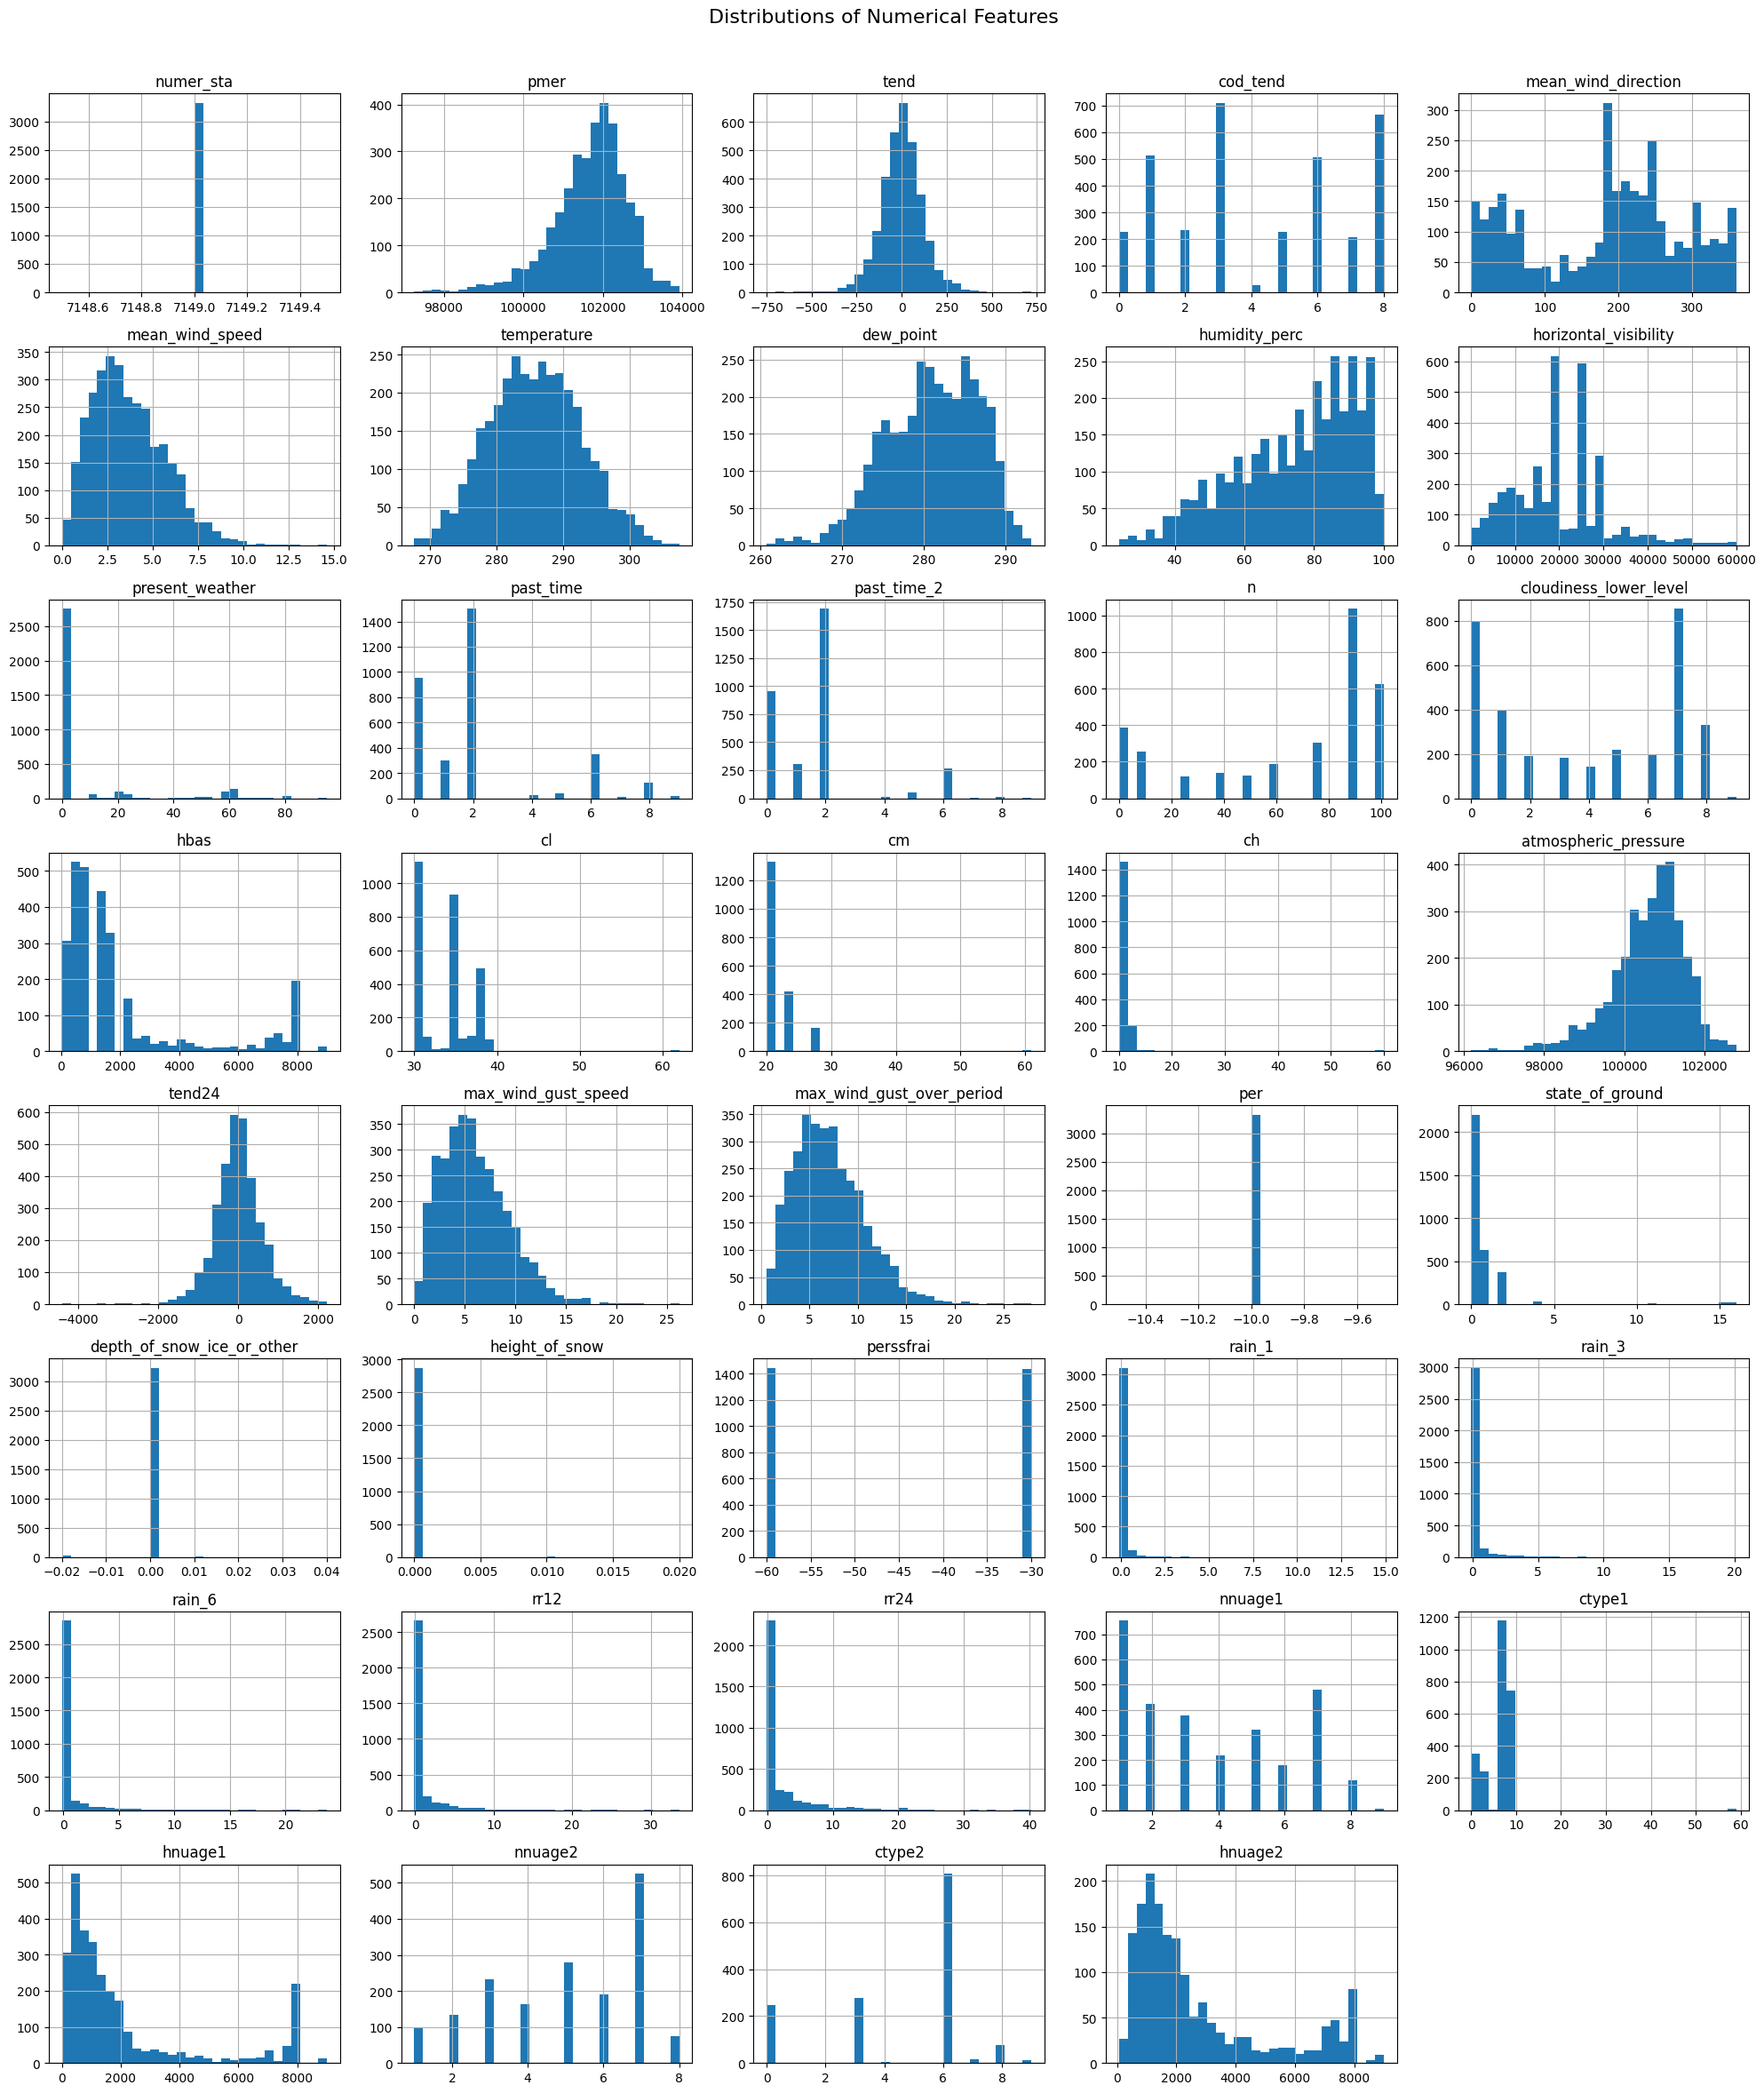

In [19]:
# Select numerical columns
numerical_features_weather = weather.select_dtypes(include=['number'])

# Determine the number of plots
num_features = numerical_features_weather.shape[1]

# Calculate the grid layout
cols = 5  # You can adjust the number of columns as needed
rows = math.ceil(num_features / cols)

# Plot histograms for all numerical features
numerical_features_weather.hist(bins=30, figsize=(cols * 4, rows * 3), layout=(rows, cols))
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the suptitle
plt.show()

In [20]:
# Find columns with null values and their counts
null_columns = weather.isnull().sum()[weather.isnull().sum() > 0].sort_values()

# Print columns with null values
print("Columns with null values and their counts:")
print(null_columns)

Columns with null values and their counts:
cloudiness_lower_level           5
rain_3                           6
past_time                        7
rain_1                           9
past_time_2                     10
tend24                          10
max_wind_gust_speed             10
rain_6                          16
rr12                            22
rr24                            24
depth_of_snow_ice_or_other      49
state_of_ground                 52
n                              156
cl                             413
height_of_snow                 445
perssfrai                      445
nnuage1                        449
hbas                           453
hnuage1                        455
ctype1                         798
cm                            1381
nnuage2                       1627
hnuage2                       1627
ch                            1644
ctype2                        1879
dtype: int64


In [21]:
# We check the definition of the columns with still high nan values and determine which to drop based on their relevance for the prediction


In [22]:
weather = weather.drop(columns=['nnuage1','ctype1','hnuage1','nnuage2','hnuage2','tend24','perssfrai','pmer','tend','cod_tend','n','hbas','cl','ch','cm','ctype2','numer_sta'])

In [23]:
#Here we interpolate all the numerical values:
columns_to_interpolate = ['cloudiness_lower_level', 'rain_3', 'rain_1', 'max_wind_gust_speed', 'rain_6', 'rr12', 'rr24', 'depth_of_snow_ice_or_other']

# Perform linear interpolation for each column
for col in columns_to_interpolate:
    weather[col] = weather[col].interpolate(method='linear', limit_direction='both')

# Verify that there are no more null values in these columns
print(weather[columns_to_interpolate].isnull().sum())


cloudiness_lower_level        0
rain_3                        0
rain_1                        0
max_wind_gust_speed           0
rain_6                        0
rr12                          0
rr24                          0
depth_of_snow_ice_or_other    0
dtype: int64


In [24]:
# Forward and backward fill the categorical variables
weather['past_time'] = weather['past_time'].fillna(method='ffill').fillna(method='bfill')
weather['past_time_2'] = weather['past_time_2'].fillna(method='ffill').fillna(method='bfill')
weather['state_of_ground'] = weather['state_of_ground'].fillna(method='ffill').fillna(method='bfill')

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2217314674.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['past_time'] = weather['past_time'].fillna(method='ffill').fillna(method='bfill')
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2217314674.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['past_time_2'] = weather['past_time_2'].fillna(method='ffill').fillna(method='bfill')
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2217314674.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['state_of_ground'] = weather['state_of_ground'].fillna(method='ffill').fillna(method='bfill')


In [25]:
# Assume 0 snowfall for missing values
weather['height_of_snow'] = weather['height_of_snow'].fillna(0)  

In [26]:
# drop any further duplicates we might not have seen
weather = weather.drop_duplicates()

# At this point, look at a correlation matrix (OR JUST drop more arbitrary columns)

In [27]:
weather

,date,mean_wind_direction,mean_wind_speed,temperature,dew_point,humidity_perc,horizontal_visibility,present_weather,past_time,past_time_2,...,max_wind_gust_over_period,per,state_of_ground,depth_of_snow_ice_or_other,height_of_snow,rain_1,rain_3,rain_6,rr12,rr24
0,2021-01-01 00:00:00,270,1.8,272.75,272.15,96,990,2,0.0,0.0,...,2.5,-10,1.0,0.00,0.00,0.0,0.0,0.0,0.0,2.0
1,2021-01-01 03:00:00,300,1.7,271.25,270.95,98,210,40,0.0,0.0,...,2.2,-10,1.0,0.00,0.00,0.0,0.0,0.0,0.0,1.2
2,2021-01-01 06:00:00,290,2.6,271.95,271.65,98,3660,3,1.0,1.0,...,3.2,-10,1.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0
3,2021-01-01 09:00:00,280,1.7,272.45,272.05,97,3500,10,1.0,1.0,...,2.3,-10,13.0,0.01,0.01,0.0,0.2,0.2,0.2,0.2
4,2021-01-01 12:00:00,50,1.0,276.95,274.15,82,8000,2,2.0,2.0,...,4.4,-10,11.0,-0.01,0.00,0.0,0.0,0.2,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,2020-09-30 09:00:00,230,4.4,289.95,286.85,82,18000,3,2.0,2.0,...,7.1,-10,0.0,0.00,0.00,0.0,0.0,0.0,0.0,2.2
3318,2020-09-30 12:00:00,190,4.9,292.05,285.55,66,25000,1,2.0,2.0,...,7.2,-10,0.0,0.00,0.00,0.0,0.2,0.2,0.2,1.6
3319,2020-09-30 15:00:00,190,4.1,291.55,286.45,72,25000,1,2.0,2.0,...,8.4,-10,0.0,0.00,0.00,0.0,0.0,0.2,0.2,0.2
3320,2020-09-30 18:00:00,190,2.7,290.15,285.25,73,40820,3,2.0,2.0,...,5.2,-10,0.0,0.00,0.00,0.0,0.0,0.0,0.2,0.2


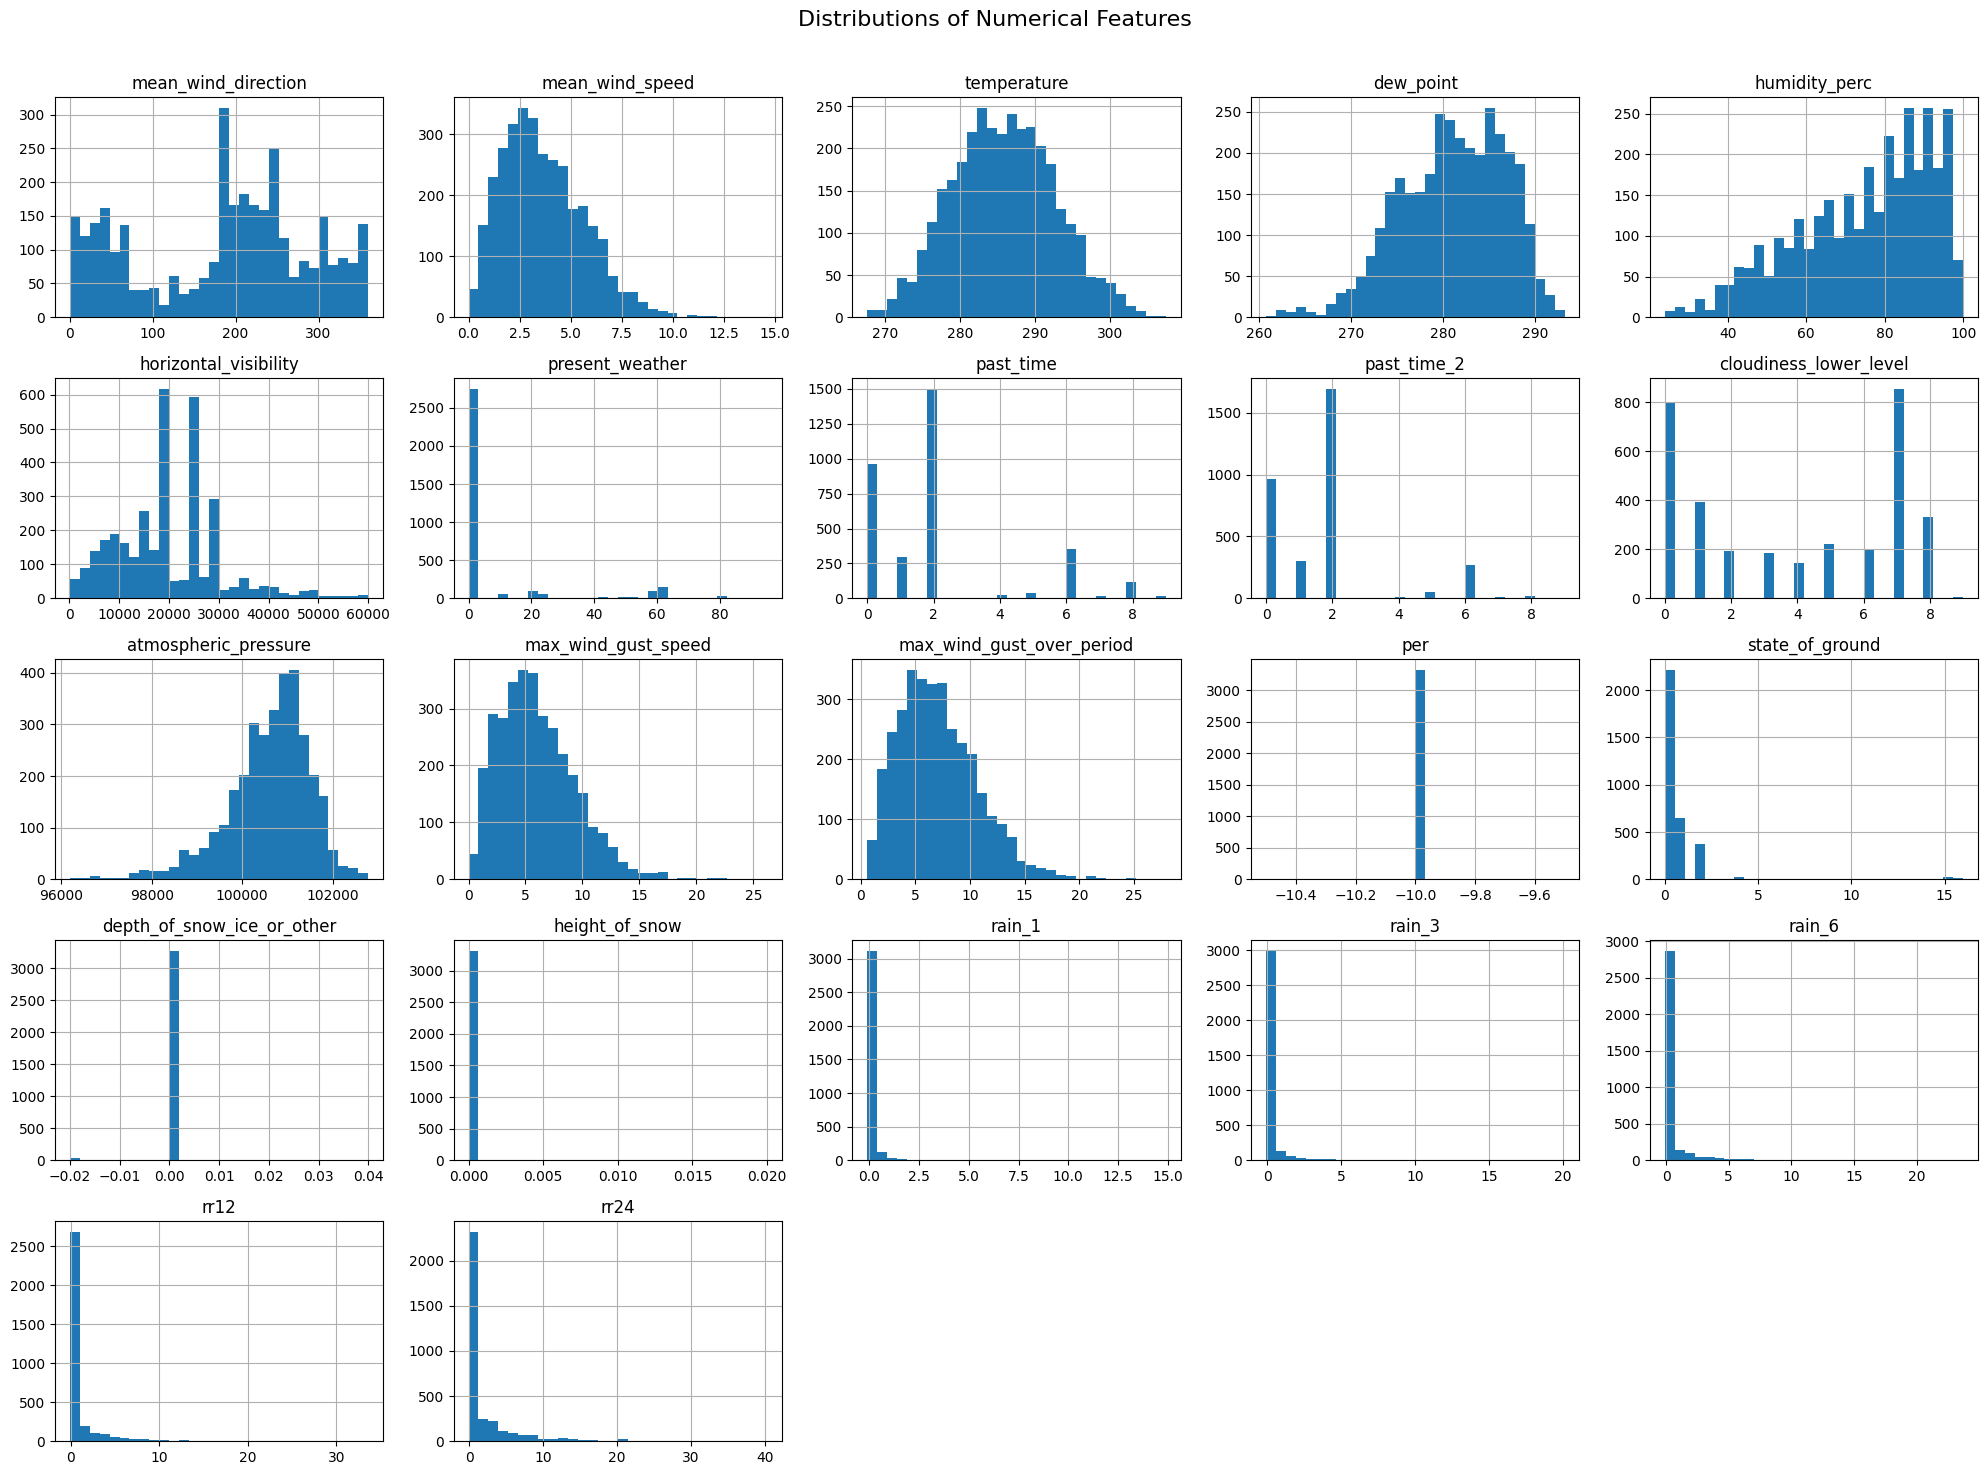

In [28]:
# Select numerical columns
numerical_features_weather = weather.select_dtypes(include=['number'])

# Determine the number of plots
num_features = numerical_features_weather.shape[1]

# Calculate the grid layout
cols = 5  # You can adjust the number of columns as needed
rows = math.ceil(num_features / cols)

# Plot histograms for all numerical features
numerical_features_weather.hist(bins=30, figsize=(cols * 4, rows * 3), layout=(rows, cols))
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit the suptitle
plt.show()

# Merge external data

In [29]:
def merge_external_data(data, weather):
    data['date'] = pd.to_datetime(data['date']).astype('datetime64[ns]')
    weather['date'] = pd.to_datetime(weather['date']).astype('datetime64[ns]')
    data["orig_index"] = np.arange(data.shape[0])
    merged_df = pd.merge_asof(
        data.sort_values("date"),
        weather.sort_values("date"),
        on="date"
    )
    merged_df = merged_df.sort_values("orig_index")
    del merged_df["orig_index"]
    return merged_df

In [30]:
# data merging

data['date'] = pd.to_datetime(data['date']).astype('datetime64[ns]')
weather['date'] = pd.to_datetime(weather['date']).astype('datetime64[ns]')

merged_data = merge_external_data(data, weather)
merged_data


,counter_id,counter_name,date,coordinates,log_bike_count,weekend_day,season,holidays,strike,is_rush_hour,...,max_wind_gust_over_period,per,state_of_ground,depth_of_snow_ice_or_other,height_of_snow,rain_1,rain_3,rain_6,rr12,rr24
0,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 01:00:00,"48.840801,2.333233",1.609438,0,autumn,0,0,0,...,3.1,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 02:00:00,"48.840801,2.333233",0.000000,0,autumn,0,0,0,...,3.1,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 03:00:00,"48.840801,2.333233",1.098612,0,autumn,0,0,0,...,1.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 04:00:00,"48.840801,2.333233",2.833213,0,autumn,0,0,0,...,1.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253,100049407-353255860,152 boulevard du Montparnasse E-O,2020-09-01 05:00:00,"48.840801,2.333233",4.060443,0,autumn,0,0,0,...,1.5,-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496599,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 19:00:00,"48.8484,2.27586",3.663562,0,autumn,0,0,1,...,12.1,-10,1.0,0.0,0.0,0.6,0.6,0.6,0.6,1.8
496642,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 20:00:00,"48.8484,2.27586",3.555348,0,autumn,0,0,0,...,12.1,-10,1.0,0.0,0.0,0.6,0.6,0.6,0.6,1.8
496705,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 21:00:00,"48.8484,2.27586",3.526361,0,autumn,0,0,0,...,4.4,-10,1.0,0.0,0.0,0.0,0.0,0.6,0.6,1.8
496743,100042374-109042374,Voie Georges Pompidou SO-NE,2021-09-09 22:00:00,"48.8484,2.27586",3.258097,0,autumn,0,0,0,...,4.4,-10,1.0,0.0,0.0,0.0,0.0,0.6,0.6,1.8


In [31]:
# Once merged, do a correlation matrix to see if there are any additional features that should be dropped

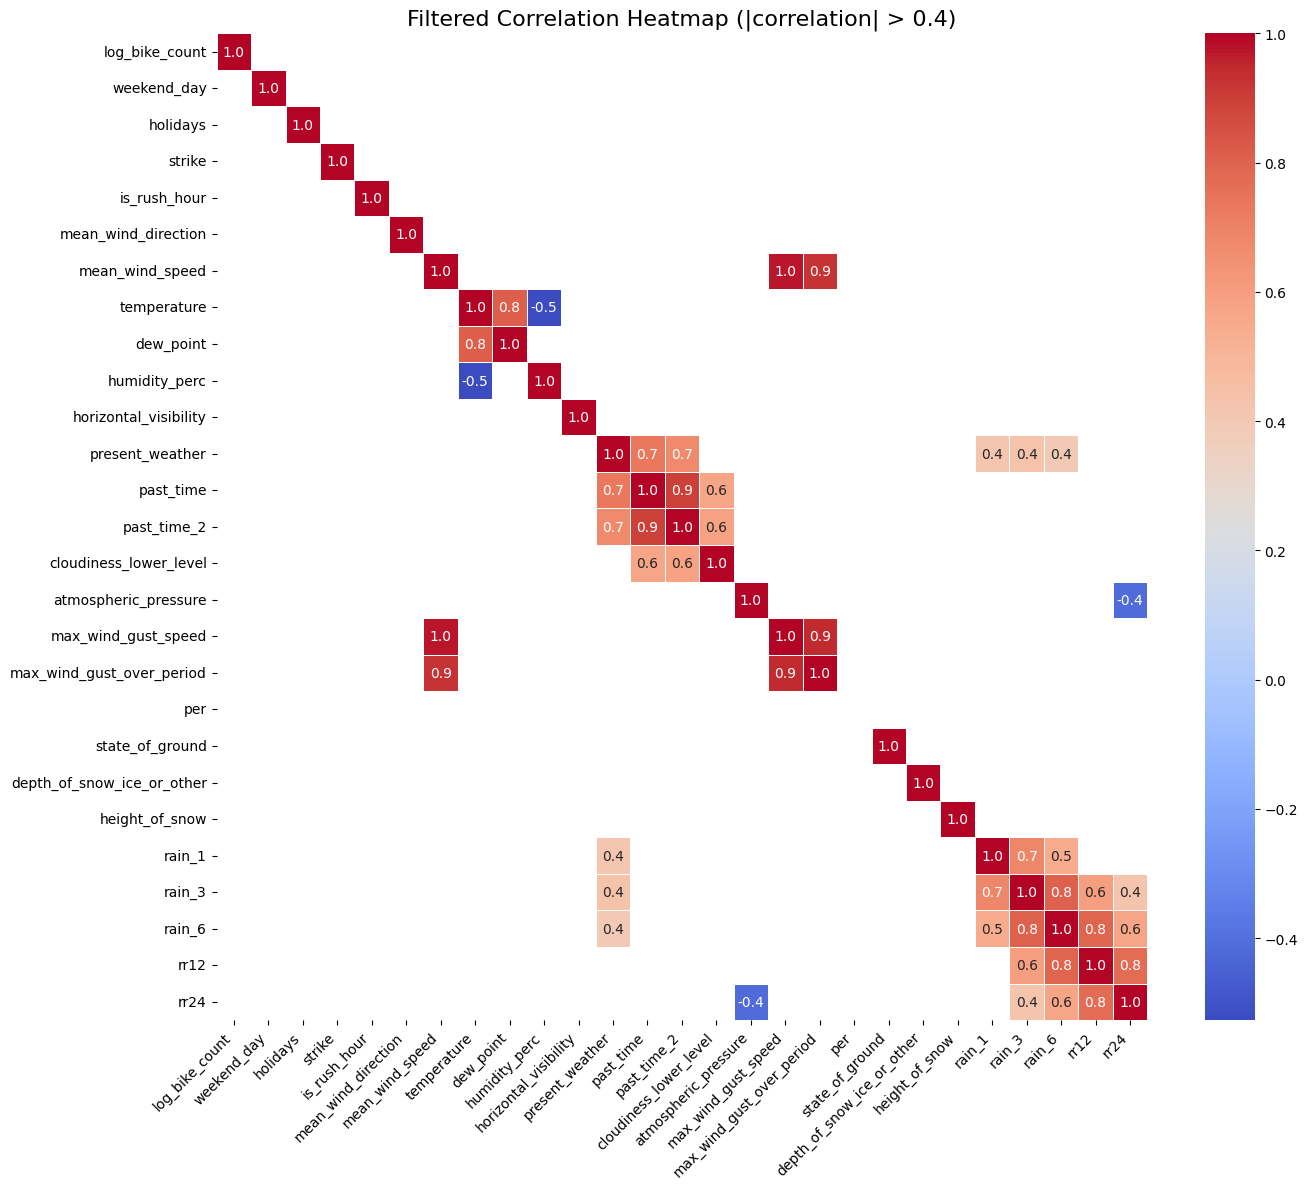

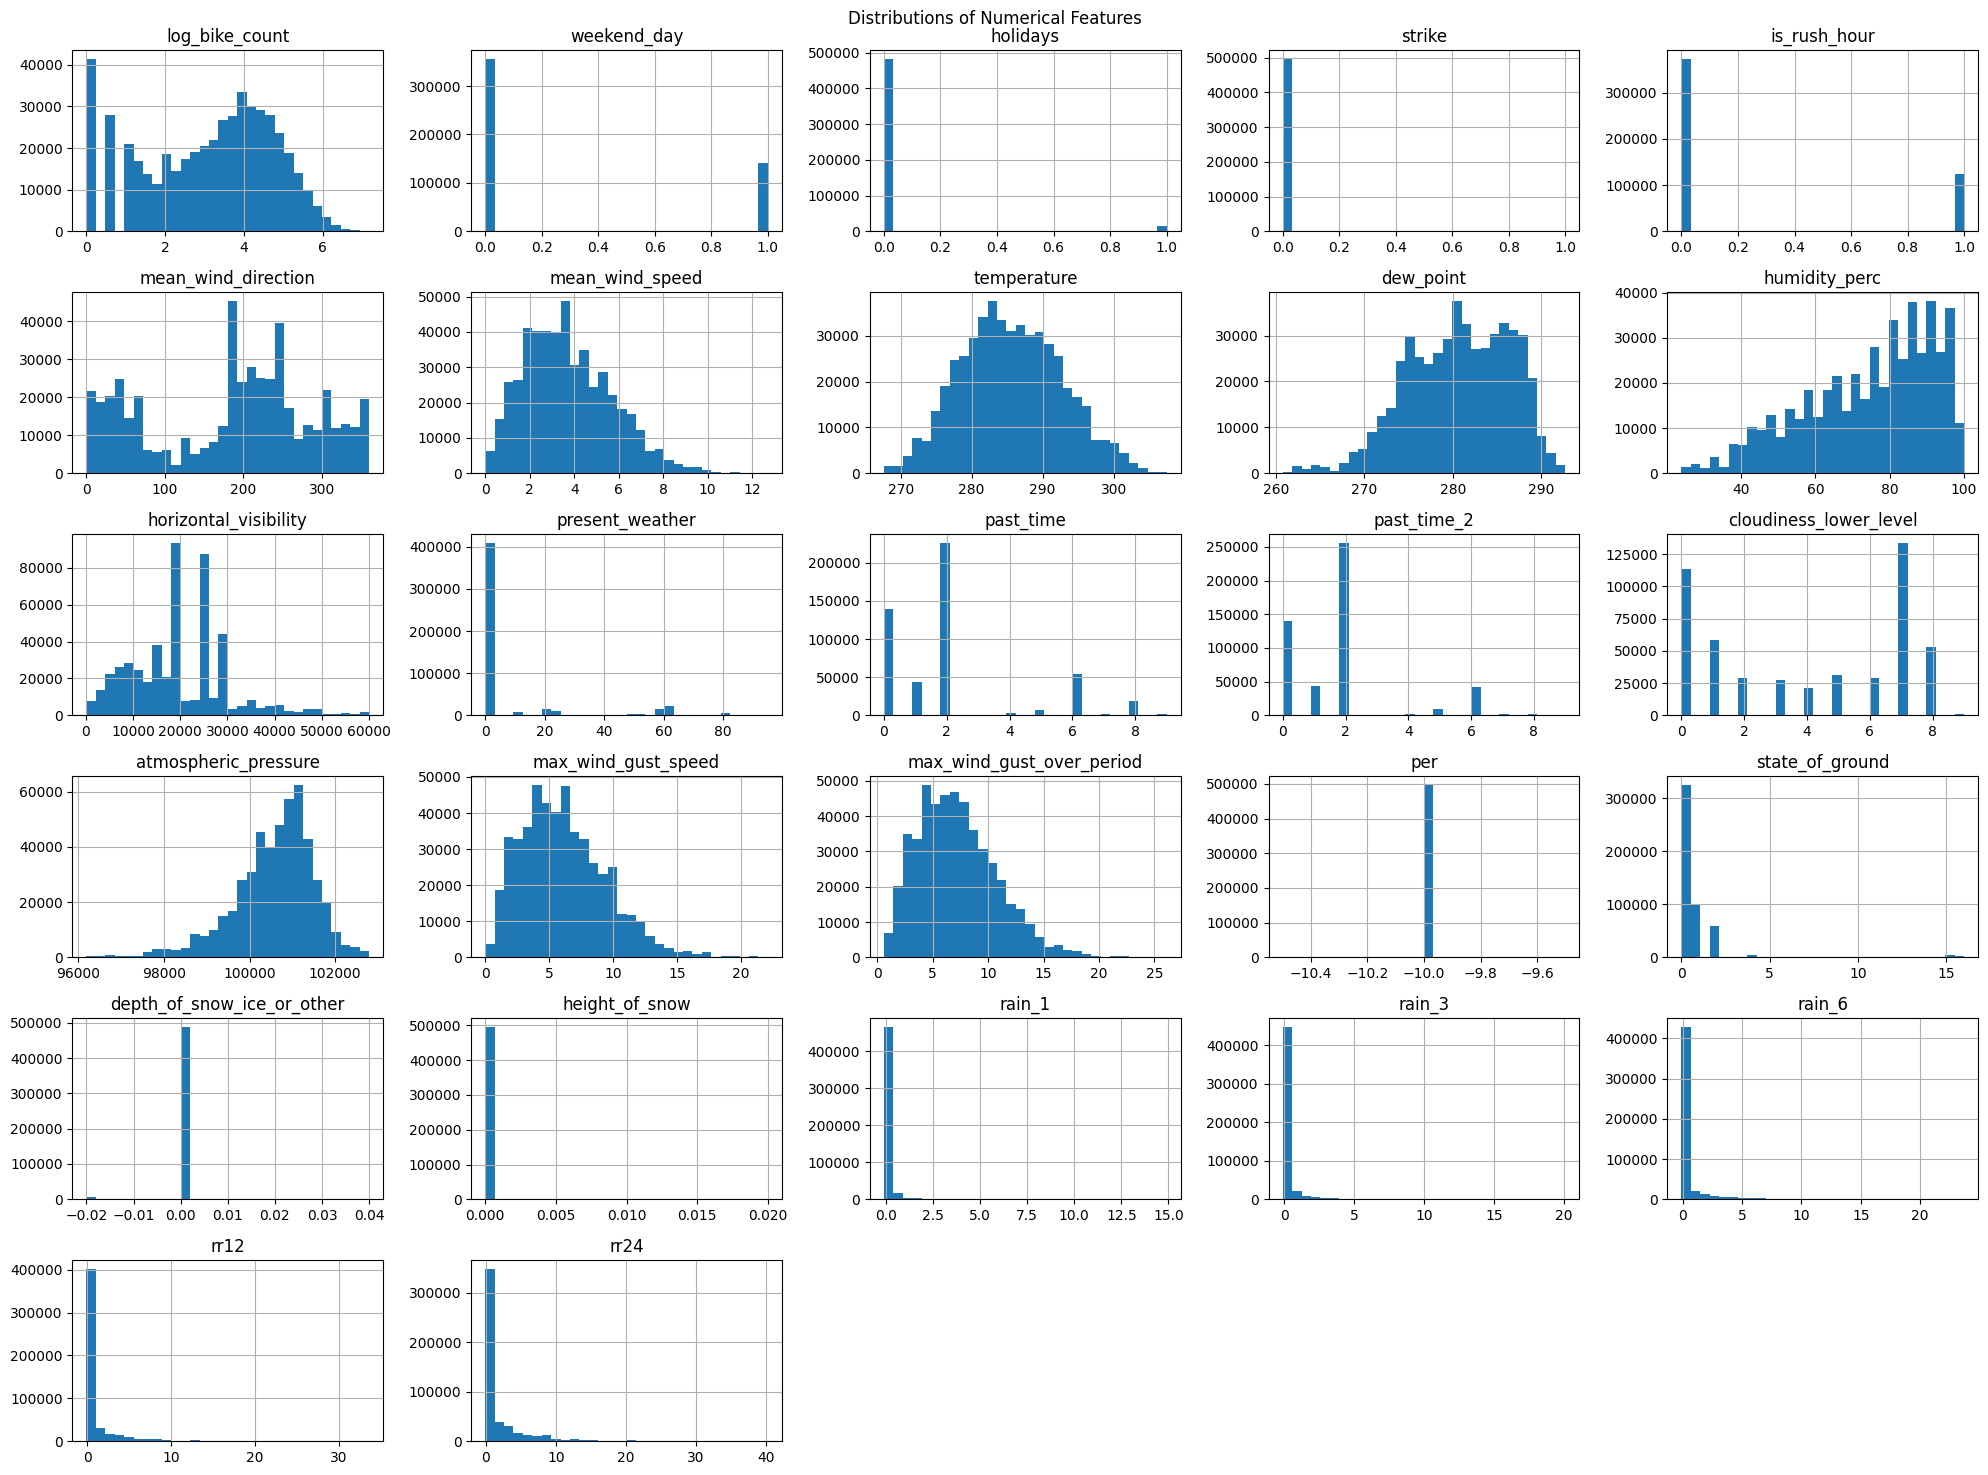

In [32]:
numerical_features_merged = merged_data.select_dtypes(include=['int64', 'float64','int32']).columns

# Compute the correlation matrix for numerical features
corr_matrix = merged_data[numerical_features_merged].corr()

# Mask the correlations below 0.4 and above -0.4
filtered_corr = corr_matrix.where(np.abs(corr_matrix) >= 0.4)

# Plot the filtered correlation heatmap with better visibility
plt.figure(figsize=(14, 12))
sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".1f",  # Format numbers with 1 decimal place
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 10},  # Increase font size of annotations
    cbar=True
)
plt.title("Filtered Correlation Heatmap (|correlation| > 0.4)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.tight_layout()  # Ensure labels fit properly
plt.show()

# Plot histograms for each numerical variable
merged_data[numerical_features_merged].hist(bins=30, figsize=(20,15))
plt.suptitle("Distributions of Numerical Features")
plt.tight_layout()
plt.show()

In [33]:
# For second cross val function
y = merged_data['log_bike_count']

X = merged_data.drop(columns=['log_bike_count'])

In [34]:
# Separate numerical and categorical columns
# To check if there are any remaining variables to encoder
# We know we don't have to check in y because we dropped all columns except 'log bike count'
numerical_features_merged = X.select_dtypes(include=['int64', 'float64','int32']).columns
categorical_features_merged = X.select_dtypes(include=['object', 'category']).columns
other_features = X.select_dtypes(include=['datetime']).columns


print("Numerical features:", numerical_features_merged)
print("Categorical features:", categorical_features_merged)
print("other features:", other_features)

Numerical features: Index(['weekend_day', 'holidays', 'strike', 'is_rush_hour',
       'mean_wind_direction', 'mean_wind_speed', 'temperature', 'dew_point',
       'humidity_perc', 'horizontal_visibility', 'present_weather',
       'past_time', 'past_time_2', 'cloudiness_lower_level',
       'atmospheric_pressure', 'max_wind_gust_speed',
       'max_wind_gust_over_period', 'per', 'state_of_ground',
       'depth_of_snow_ice_or_other', 'height_of_snow', 'rain_1', 'rain_3',
       'rain_6', 'rr12', 'rr24'],
      dtype='object')
Categorical features: Index(['counter_id', 'counter_name', 'coordinates', 'season'], dtype='object')
other features: Index(['date'], dtype='object')


In [35]:
# random train and test datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

In [36]:
# Here we printing the shape of the train and test datasets

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
) 
print(
    f'Test: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=422302,  2020-09-01 01:00:00 to 2021-09-09 23:00:00
Test: n_samples=74525,  2020-09-01 01:00:00 to 2021-09-09 23:00:00


In [37]:
# Here we create a new train_test_split function to take panel data into consideration

In [38]:
'''
def panel_time_series_split(data, time_column, panel_column, target_column, test_size=0.15):
    """
    Splits a panel time series dataset into training and validation sets based on time.

    Parameters:
    - data (pd.DataFrame): The full dataset containing panel and time data.
    - time_column (str): The name of the time column (e.g., 'timestamp').
    - panel_column (str): The name of the panel identifier column (e.g., 'counter').
    - target_column (str): The name of the target column.
    - test_size (float): The proportion of the dataset to allocate for validation (default 15%).

    Returns:
    - X_train, X_valid, y_train, y_valid (pd.DataFrame or pd.Series): Training and validation data.
    """
    # Step 1: Sort by panel and time
    data = data.sort_values(by=[panel_column, time_column])
    
    # Step 2: Calculate the split time boundary
    split_date = data[time_column].quantile(1 - test_size)
    
    # Step 3: Split into train and validation
    train_data = data[data[time_column] <= split_date]
    valid_data = data[data[time_column] > split_date]
    
    # Step 4: Separate features and target
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_valid = valid_data.drop(columns=[target_column])
    y_valid = valid_data[target_column]
    
    # Step 5: Print summary of selected data
    print("=== Split Summary ===")
    print(f"Training Data: {len(X_train)} rows")
    print(f"  - Time Range: {train_data[time_column].min()} to {train_data[time_column].max()}")
    print(f"Validation Data: {len(X_valid)} rows")
    print(f"  - Time Range: {valid_data[time_column].min()} to {valid_data[time_column].max()}")
    
    return X_train, X_valid, y_train, y_valid'''

'\ndef panel_time_series_split(data, time_column, panel_column, target_column, test_size=0.15):\n    """\n    Splits a panel time series dataset into training and validation sets based on time.\n\n    Parameters:\n    - data (pd.DataFrame): The full dataset containing panel and time data.\n    - time_column (str): The name of the time column (e.g., \'timestamp\').\n    - panel_column (str): The name of the panel identifier column (e.g., \'counter\').\n    - target_column (str): The name of the target column.\n    - test_size (float): The proportion of the dataset to allocate for validation (default 15%).\n\n    Returns:\n    - X_train, X_valid, y_train, y_valid (pd.DataFrame or pd.Series): Training and validation data.\n    """\n    # Step 1: Sort by panel and time\n    data = data.sort_values(by=[panel_column, time_column])\n    \n    # Step 2: Calculate the split time boundary\n    split_date = data[time_column].quantile(1 - test_size)\n    \n    # Step 3: Split into train and valida

In [39]:
'''# Example dataset: Replace this with your actual dataset
data = pd.DataFrame({
    'counter': ['A'] * 100 + ['B'] * 100,
    'timestamp': pd.date_range(start='2020-09-01 01:00:00', periods=100, freq='H').tolist() +
                 pd.date_range(start='2020-09-01 01:00:00', periods=100, freq='H').tolist(),
    'features': range(200),
    'target': [1] * 100 + [0] * 100
})





# Call the function
X_train, X_valid, y_train, y_valid = panel_time_series_split(
    data=X,
    time_column='date',
    panel_column='counter_name',
    target_column='target',
    test_size=0.15
)

# Inspect the results
print("=== Training Set ===")
print(X_train.head())
print("\n=== Validation Set ===")
print(X_valid.head())




X_train, X_valid, y_train, y_valid = panel_time_series_split(X, y, test_size=0.15, random_state=42)

'''

'# Example dataset: Replace this with your actual dataset\ndata = pd.DataFrame({\n    \'counter\': [\'A\'] * 100 + [\'B\'] * 100,\n    \'timestamp\': pd.date_range(start=\'2020-09-01 01:00:00\', periods=100, freq=\'H\').tolist() +\n                 pd.date_range(start=\'2020-09-01 01:00:00\', periods=100, freq=\'H\').tolist(),\n    \'features\': range(200),\n    \'target\': [1] * 100 + [0] * 100\n})\n\n\n\n\n\n# Call the function\nX_train, X_valid, y_train, y_valid = panel_time_series_split(\n    data=X,\n    time_column=\'date\',\n    panel_column=\'counter_name\',\n    target_column=\'target\',\n    test_size=0.15\n)\n\n# Inspect the results\nprint("=== Training Set ===")\nprint(X_train.head())\nprint("\n=== Validation Set ===")\nprint(X_valid.head())\n\n\n\n\nX_train, X_valid, y_train, y_valid = panel_time_series_split(X, y, test_size=0.15, random_state=42)\n\n'

In [40]:
# Cross val for second function
# Then we have to drop date from each column
# X = merged_data.drop(columns=['log_bike_count',' date'])

In [41]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the date columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [42]:
# Step 2: Create a FunctionTransformer for date encoding
date_encoder = FunctionTransformer(_encode_dates, validate=False)

# Step 3: Define categorical and date columns
cat_cols = ["counter_id", "coordinates", "season",'counter_name']
date_cols = ["date"]  # Columns containing date information

# Step 4: Define the preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        # Apply the date encoder to date columns
        ("date", date_encoder, date_cols),
        # Apply one-hot encoding to categorical columns
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="passthrough"  # Leave remaining columns as they are
)

xgb = XGBRegressor(random_state=42)

pipe = Pipeline(steps=[
                ('preprocess', preprocess),
                ('regressor', xgb)
])

In [43]:
param_grid = {
    'regressor__max_depth': [5, 8, 15],
    'regressor__n_estimators': [700, 750, 800],
    'regressor__learning_rate': [0.1, 0.01]
}


# Explores multiple hyperparameters combinations for the model
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search_results = grid_search.fit(X_train, y_train)
print("The best parameters are ",grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
The best parameters are  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 800}


In [44]:
# After identifying the best hyperparameters, the model is retrained on the entire training set.
# This step ensures the final model uses the best configuration found during grid search.

xgb = grid_search.best_estimator_
xgb.fit(X_train, y_train)

C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  FunctionTransformer(func=<function _encode_dates at 0x000001B0D7DB29D0>),
                                                  ['date']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['counter_id', 'coordinates',
                                                   'season',
                                                   'counter_name'])])),
                ('regressor',
                 XGBRegressor(base_score=None, boo...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [45]:
# Predictions: Uses the optimized model to make predictions on the validation set.

# Evaluation: Computes the Root Mean Squared Error (RMSE) as the performance metric. 
# RMSE provides an interpretable measure of how well the model's predictions match the true values.

y_valid_pred = xgb.predict(X_valid)
rmse = MSE(y_valid, y_valid_pred)
print(f"The RMSE is: {np.sqrt(rmse)}")

The RMSE is: 0.34363708800380527


In [46]:
# To illustrate the difference better:


# Evaluate RMSE for Train and Validation Sets
print("=== Model Performance ===")

# Training set RMSE
train_rmse = MSE(y_train, xgb.predict(X_train), squared=False)
print(f"Train set, RMSE = {train_rmse:.2f}")

# Validation set RMSE
valid_rmse = MSE(y_valid, xgb.predict(X_valid), squared=False)
print(f"Validation set, RMSE = {valid_rmse:.2f}")


=== Model Performance ===
Train set, RMSE = 0.29
Validation set, RMSE = 0.34


C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# We can use this simple baseline to see if our model is performing better

# than a simple mean prediction.
print("Baseline mean prediction.")

print(
    f"Train set, RMSE={MSE(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={MSE(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.66
Test set, RMSE=1.66


C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\phili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Early stopping criterion model

[0]	validation_0-rmse:1.34782	validation_1-rmse:1.34857
[1]	validation_0-rmse:1.16201	validation_1-rmse:1.16341
[2]	validation_0-rmse:1.04097	validation_1-rmse:1.04220
[3]	validation_0-rmse:0.96383	validation_1-rmse:0.96549
[4]	validation_0-rmse:0.90924	validation_1-rmse:0.91084
[5]	validation_0-rmse:0.87332	validation_1-rmse:0.87487
[6]	validation_0-rmse:0.84838	validation_1-rmse:0.85005
[7]	validation_0-rmse:0.81821	validation_1-rmse:0.81921
[8]	validation_0-rmse:0.80032	validation_1-rmse:0.80224
[9]	validation_0-rmse:0.77014	validation_1-rmse:0.77270
[10]	validation_0-rmse:0.74664	validation_1-rmse:0.74859
[11]	validation_0-rmse:0.73398	validation_1-rmse:0.73636
[12]	validation_0-rmse:0.72193	validation_1-rmse:0.72428
[13]	validation_0-rmse:0.71198	validation_1-rmse:0.71461
[14]	validation_0-rmse:0.70329	validation_1-rmse:0.70611
[15]	validation_0-rmse:0.69225	validation_1-rmse:0.69527
[16]	validation_0-rmse:0.66214	validation_1-rmse:0.66496
[17]	validation_0-rmse:0.65354	validation

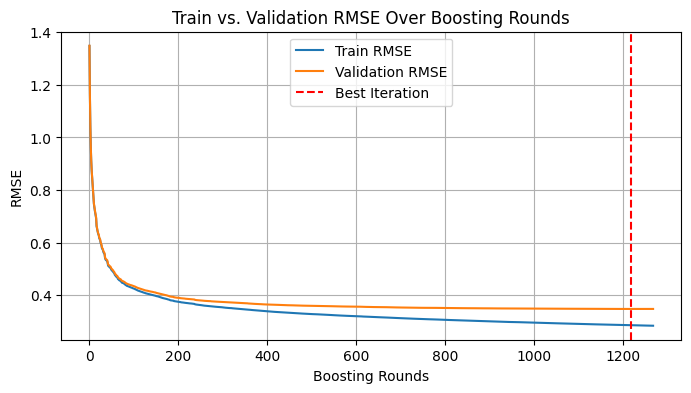

In [48]:
# Step 2: Create a FunctionTransformer for date encoding
date_encoder = FunctionTransformer(_encode_dates, validate=False)

# Step 3: Define categorical and date columns
cat_cols = ["counter_id", "coordinates", "season", 'counter_name']
date_cols = ["date"]  # Columns containing date information

# Step 4: Define the preprocessing pipeline
preprocess = ColumnTransformer(
    transformers=[
        # Apply the date encoder to date columns
        ("date", date_encoder, date_cols),
        # Apply one-hot encoding to categorical columns
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="passthrough"  # Leave remaining columns as they are
)



# Apply preprocessing to training and validation data
X_train_preprocessed = preprocess.fit_transform(X_train)
X_valid_preprocessed = preprocess.transform(X_valid)

# Define the XGBRegressor with early stopping
xgb = XGBRegressor(
    random_state=42,
    n_estimators=2000,         # Maximum number of boosting rounds
    early_stopping_rounds=50,  # Stop training if no improvement for 50 rounds
    eval_metric="rmse",        # Use RMSE as the evaluation metric
)

# Train the model with early stopping
xgb.fit(
    X_train_preprocessed,
    y_train,
    eval_set=[
        (X_train_preprocessed, y_train),  # Preprocessed training set
        (X_valid_preprocessed, y_valid),  # Preprocessed validation set
    ],
    verbose=True,  # Set to True for training logs
)

# Access the best iteration
best_iteration = xgb.best_iteration
print(f"Best iteration: {best_iteration}")

# Make predictions
y_valid_pred = xgb.predict(X_valid_preprocessed)

# Evaluate the model
validation_rmse = np.sqrt(MSE(y_valid, y_valid_pred))
print(f"Validation RMSE: {validation_rmse:.2f}")

# Plot training and validation RMSE over boosting rounds
eval_results = xgb.evals_result()
train_rmse = eval_results["validation_0"]["rmse"]
valid_rmse = eval_results["validation_1"]["rmse"]

plt.figure(figsize=(8, 4))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(valid_rmse, label="Validation RMSE")
plt.axvline(best_iteration, color="red", linestyle="--", label="Best Iteration")
plt.title("Train vs. Validation RMSE Over Boosting Rounds")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


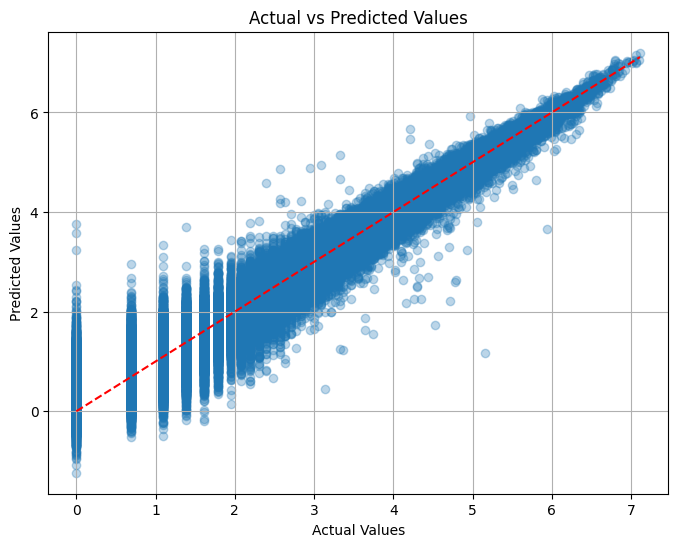

In [49]:
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_valid_pred, alpha=0.3)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.grid()
plt.show()

Now we check our prediction: 

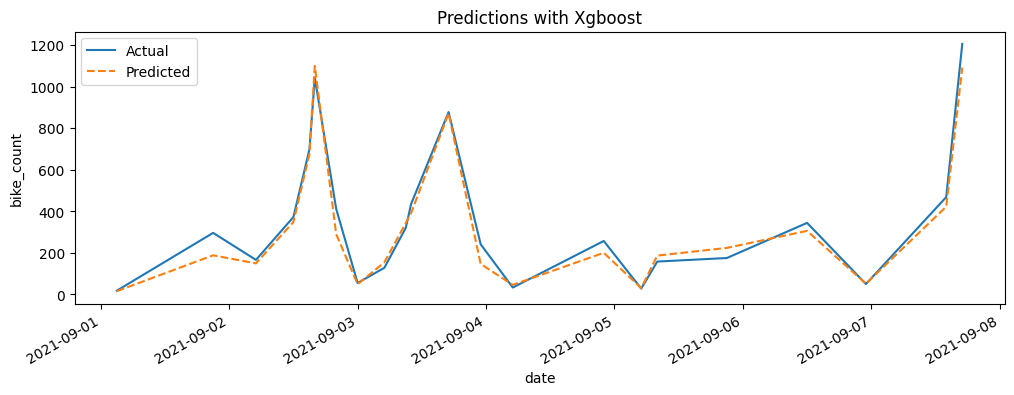

In [50]:

pipe.fit(X_train, y_train)

mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N") &
    (X_valid["date"] > pd.to_datetime("2021-09-01")) &
    (X_valid["date"] < pd.to_datetime("2021-09-08"))
)


df_viz = X_valid.loc[mask].copy()

df_viz["bike_count (predicted)"] = np.exp(pipe.predict(df_viz)) - 1

df_viz["bike_count"] = np.exp(y_valid[mask]) - 1

df_viz = df_viz.sort_values('date')

fig, ax = plt.subplots(figsize=(12, 4))

# Plot actual bike counts
df_viz.plot(x="date", y="bike_count", ax=ax, label="Actual")

# Plot predicted bike counts
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, label="Predicted", linestyle="--")

# Add titles and labels
ax.set_title("Predictions with Xgboost")
ax.set_ylabel("bike_count")
plt.legend()
plt.show()



A useful way to visualize the error is to plot y_pred as a function of y_true

# final testing

In [70]:
X_test = pd.read_parquet('data/final_test.parquet')

# We now apply exactly the same transformations we did for our train dataset (data)

X_test['date'] = pd.to_datetime(X_test['date']).astype('datetime64[ns]')

print(f"Data ranges from {X_test['date'].min()} to {X_test['date'].max()}")

Data ranges from 2021-09-10 01:00:00 to 2021-10-18 21:00:00


In [71]:
X_test

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
...,...,...,...,...,...,...,...,...,...,...
51435,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 11:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51436,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51437,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 17:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980
51438,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-10-18 18:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980


In [72]:
X_test = X_test.drop(
    [
        "site_id",
        "site_name",
        "counter_installation_date",
        "counter_technical_id",
        "latitude",
        "longitude",
    ],
    axis=1,
)

In [73]:
X_test = extract_date_features(X_test)
X_test = strikes(X_test)
X_test = add_rush_hour(X_test)

C:\Users\phili\AppData\Local\Temp\ipykernel_28336\660285707.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data['strike'] = data['date'].isin(greves['Date']).astype(int)


In [74]:
weather = pd.read_csv('external_data/external_data.csv', parse_dates=["date"])
data['date'] = pd.to_datetime(data['date'])
weather['date'] = pd.to_datetime(weather['date'])
# Define the renaming dictionary
rename_dict = {
    'dd': 'mean_wind_direction',
    'ff': 'mean_wind_speed',
    't': 'temperature',
    'td': 'dew_point',
    'u': 'humidity_perc',
    'vv': 'horizontal_visibility',
    'ww': 'present_weather',  # potentially categorical - check
    'w1': 'past_time',
    'w2': 'past_time_2',  # potentially to take out
    'nbas': 'cloudiness_lower_level',
    'pres': 'atmospheric_pressure',
    'raf10': 'max_wind_gust_speed',
    'rafper': 'max_wind_gust_over_period',
    'etat_sol': 'state_of_ground',
    'ht_neige': 'depth_of_snow_ice_or_other',
    'ssfrai': 'height_of_snow',
    'rr1': 'rain_1',
    'rr3': 'rain_3',
    'rr6': 'rain_6',
    'rr9': 'rain_9'
}

# Rename the columns in-place
weather.rename(columns=rename_dict, inplace=True)

threshold = 0.7  # 90% threshold

# Calculate the percentage of NaN values for each column
nan_percentage = weather.isnull().mean()

# Identify columns where NaN percentage is greater than the threshold
columns_to_drop = nan_percentage[nan_percentage > threshold].index

# Print the columns that will be dropped
print(f"Columns dropped (NaN > 70%): {list(columns_to_drop)}")

# Drop those columns from the dataset
weather = weather.drop(columns=columns_to_drop)

weather = weather.drop(columns=['nnuage1','ctype1','hnuage1','nnuage2','hnuage2','tend24','perssfrai','pmer','tend','cod_tend','n','hbas','cl','ch','cm','ctype2','numer_sta'])

#Here we interpolate all the numerical values:
columns_to_interpolate = ['cloudiness_lower_level', 'rain_3', 'rain_1', 'max_wind_gust_speed', 'rain_6', 'rr12', 'rr24', 'depth_of_snow_ice_or_other']

# Perform linear interpolation for each column
for col in columns_to_interpolate:
    weather[col] = weather[col].interpolate(method='linear', limit_direction='both')

    # Forward and backward fill the categorical variables
weather['past_time'] = weather['past_time'].fillna(method='ffill').fillna(method='bfill')
weather['past_time_2'] = weather['past_time_2'].fillna(method='ffill').fillna(method='bfill')
weather['state_of_ground'] = weather['state_of_ground'].fillna(method='ffill').fillna(method='bfill')

weather['height_of_snow'] = weather['height_of_snow'].fillna(0)  
weather = weather.drop_duplicates()

Columns dropped (NaN > 70%): ['niv_bar', 'geop', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4']


C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2686797914.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['past_time'] = weather['past_time'].fillna(method='ffill').fillna(method='bfill')
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2686797914.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['past_time_2'] = weather['past_time_2'].fillna(method='ffill').fillna(method='bfill')
C:\Users\phili\AppData\Local\Temp\ipykernel_28336\2686797914.py:57: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather['state_of_ground'] = weather['state_of_ground'].fillna(method='ffill').fillna(method='bfill')


In [75]:
weather['date'] = pd.to_datetime(weather['date']).astype('datetime64[ns]')

merged_test_data = merge_external_data(X_test, weather)

# For second cross val function

X_test = merged_test_data

In [76]:
# Before the final test prediction, check that the test and train dataset are the same
set(X_train.columns) == set(X_test.columns)

print("Columns in X_train not in X_test:", set(X_train.columns) - set(X_test.columns))
print("Columns in X_test not in X_train:", set(X_test.columns) - set(X_train.columns))


Columns in X_train not in X_test: set()
Columns in X_test not in X_train: set()


In [77]:
# After fitting grid_search
xgb = grid_search.best_estimator_  # This is the pipeline with preprocessing + XGBRegressor

# Now just use the pipeline for predictions:
y_test_pred = xgb.predict(X_test)
y_test_pred = np.where(y_test_pred < 0, 0, y_test_pred)

In [78]:
sol = {
    'Id': list(range(len(y_test_pred))),
    'log_bike_count': y_test_pred.flatten()
}

submission = pd.DataFrame(sol)
submission.set_index("Id", inplace=True)
submission.to_csv('submission.csv')

In [79]:
import os
print(os.getcwd())


c:\Users\phili\Dropbox\POLY_CLASSES\Pyth_For_DS\Final_Project\bike_counters


Possible model improvements (for next time :)

In [80]:
'''

# let's create 3 folds, for the last 6, 4, and 2 months of the dataset
data = data_train.copy()
folds = {}
split_dates = ["2021-03-01", "2021-05-01", "2021-07-01"]
for split_date in split_dates:
    data_split_train = data[data["date"] < split_date]
    data_split_valid = data[data["date"] >= split_date]
    folds[split_date] = {
        "X_train": data_split_train.drop(
            [
                "counter_name",
                "site_id",
                "site_name",
                "bike_count",
                "log_bike_count",
                "counter_installation_date",
                "date",
                "coordinates",
                "counter_technical_id",
                "latitude",
                "longitude",
            ],
            axis=1,
        ),
        "y_train": data_split_train["log_bike_count"],
        "X_val": data_split_valid.drop(
            [
                "counter_name",
                "site_id",
                "site_name",
                "bike_count",
                "log_bike_count",
                "counter_installation_date",
                "date",
                "coordinates",
                "counter_technical_id",
                "latitude",
                "longitude",
            ],
            axis=1,
        ),
        "y_val": data_split_valid["log_bike_count"],
    }
    
    '''

'\n\n# let\'s create 3 folds, for the last 6, 4, and 2 months of the dataset\ndata = data_train.copy()\nfolds = {}\nsplit_dates = ["2021-03-01", "2021-05-01", "2021-07-01"]\nfor split_date in split_dates:\n    data_split_train = data[data["date"] < split_date]\n    data_split_valid = data[data["date"] >= split_date]\n    folds[split_date] = {\n        "X_train": data_split_train.drop(\n            [\n                "counter_name",\n                "site_id",\n                "site_name",\n                "bike_count",\n                "log_bike_count",\n                "counter_installation_date",\n                "date",\n                "coordinates",\n                "counter_technical_id",\n                "latitude",\n                "longitude",\n            ],\n            axis=1,\n        ),\n        "y_train": data_split_train["log_bike_count"],\n        "X_val": data_split_valid.drop(\n            [\n                "counter_name",\n                "site_id",\n              

In [81]:
'''
# let's do grid search
param_grid = {
    "n_estimators": [500, 1000],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "min_child_weight": [1, 3],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}
grid = list(ParameterGrid(param_grid))
best_rmse = float("inf")
best_params = None
best_iteration = None

for params in grid:
    fold_scores = []

    for split_date in folds.keys():
        # getting training and validation datasets
        X_train = folds[split_date]["X_train"]
        y_train = folds[split_date]["y_train"]
        X_val = folds[split_date]["X_val"]
        y_val = folds[split_date]["y_val"]

        # let's fit the model with the combinations of the parameters corresponding to the iteration
        model = XGBRegressor(**params, early_stopping_rounds=50, eval_metric="rmse")
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        # let's get the model with the best number of rounds obtained from the early stopping
        best_iteration = model.best_iteration
        y_pred = model.predict(X_val, iteration_range=(0, best_iteration + 1))
        rmse = RMSE(y_val, y_pred)
        fold_scores.append(rmse)

    avg_score = np.mean(fold_scores)
    if avg_score < best_rmse:
        best_rmse = avg_score
        best_params = params
        best_iteration = best_iteration  # we upgrade the best iteration only relative to the biggest training folder, corresponding to the hyperparameter combination that better performs
        '''

'\n# let\'s do grid search\nparam_grid = {\n    "n_estimators": [500, 1000],\n    "learning_rate": [0.01, 0.1],\n    "max_depth": [3, 5],\n    "min_child_weight": [1, 3],\n    "subsample": [0.8, 1.0],\n    "colsample_bytree": [0.8, 1.0],\n}\ngrid = list(ParameterGrid(param_grid))\nbest_rmse = float("inf")\nbest_params = None\nbest_iteration = None\n\nfor params in grid:\n    fold_scores = []\n\n    for split_date in folds.keys():\n        # getting training and validation datasets\n        X_train = folds[split_date]["X_train"]\n        y_train = folds[split_date]["y_train"]\n        X_val = folds[split_date]["X_val"]\n        y_val = folds[split_date]["y_val"]\n\n        # let\'s fit the model with the combinations of the parameters corresponding to the iteration\n        model = XGBRegressor(**params, early_stopping_rounds=50, eval_metric="rmse")\n        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)\n        # let\'s get the model with the best number of roun